# Disaster Tweets EDA

This notebook contains basic and/or complicated EDA.

In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import defaultdict
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
# from spellchecker import SpellChecker

# set color codes
sns.set_color_codes('pastel')
plt.style.use('ggplot')
stop_words = set(stopwords.words('english'))


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


### Loading the dataset

In [54]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [55]:
print('Number of samples in train set: {}'.format(train.shape[0]))
print('Number of samples in test set: {}'.format(test.shape[0]))

Number of samples in train set: 7613
Number of samples in test set: 3263


### Distribution of the Target

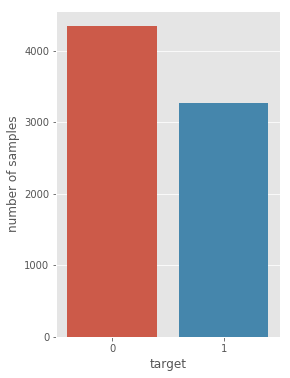

In [56]:
df = train.groupby(['target'])['id'].count()
df = df.reset_index()
df = df.rename(columns={'id': 'number of samples'})
fig, ax = plt.subplots(figsize=(4, 6))

sns.barplot(x='target', y='number of samples', data=df)

In [57]:
print('Number of disaster tweets: {}'.format(df.loc[df['target']==1]['number of samples'].values[0]))
print('Number of no disaster tweets: {}'.format(df.loc[df['target']==0]['number of samples'].values[0]))

Number of disaster tweets: 3271
Number of no disaster tweets: 4342


So, the classes are kind of balanced but we have about 1000 more samples in no disaster tweets.

### Number of Characters in Tweets

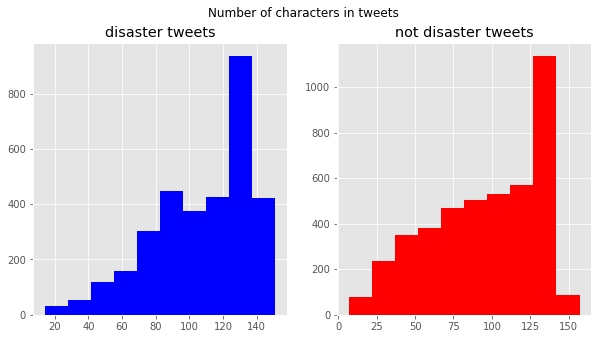

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

tweet_len = train.loc[train['target']==1]['text'].str.len()
ax1.hist(tweet_len, color='blue')
ax1.set_title('disaster tweets')
tweet_len = train.loc[train['target']==0]['text'].str.len()
ax2.hist(tweet_len, color='red')
ax2.set_title('not disaster tweets')

fig.suptitle('Number of characters in tweets')

plt.show()

Both diaster and not disaster tweets have almost same distribution on number of characters. 120 to 140 characters are most common in both groups.

### Number of Words in Tweets

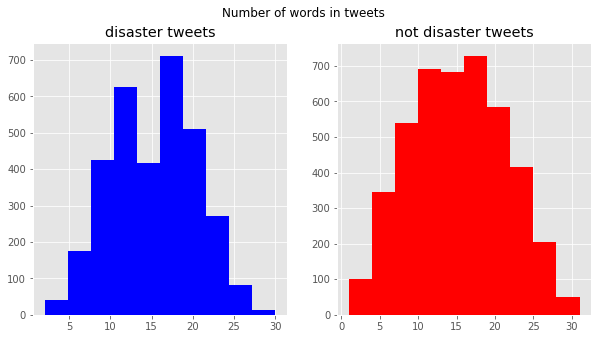

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
tweet_len = train.loc[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='blue')
ax1.set_title('disaster tweets')
tweet_len = train.loc[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color='red')
ax2.set_title('not disaster tweets')

fig.suptitle('Number of words in tweets')

plt.show()

It seems not disaster tweets have slightly more words. This might be used as a feature!

### Average Word Length in Tweets

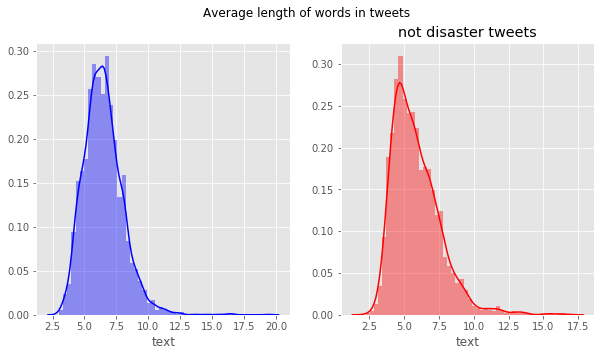

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

words = train.loc[train['target']==1] ['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(words.map(lambda x: np.mean(x)), ax=ax1, color='blue')


words = train.loc[train['target']==0] ['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(words.map(lambda x: np.mean(x)), ax=ax2, color='red')
ax2.set_title('not disaster tweets')

fig.suptitle('Average length of words in tweets')

plt.show()

Disaster and not disaster have almost same distribution over average length of words in them.

In [61]:
# funcion to make corpus
def make_corpus(df, target):
    corpus = []
    for x in df.loc[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### Stop Words

In [62]:
# make a corpus of not disaster tweets
not_disaster_corpus = make_corpus(train, target=0) # stop words for not disaster tweets
dic = defaultdict(int)

for word in not_disaster_corpus:
    if word in stop_words:
        dic[word] += 1
        
# top 10 stop words in not disaster tweets
not_disaster_top_stop_words = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

# make a corpus of disaster tweets
disaster_corpus = make_corpus(train, target=1) # stop words for disaster tweets
dic = defaultdict(int)

for word in disaster_corpus:
    if word in stop_words:
        dic[word] += 1
        
# top 10 stop words in disaster tweets
disaster_top_stop_words = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

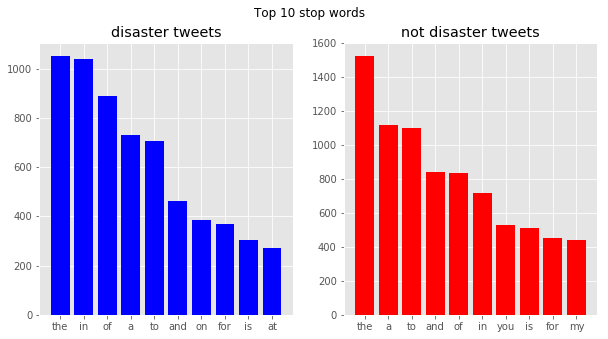

In [63]:
x1, y1 = zip(*disaster_top_stop_words)
x2, y2 = zip(*not_disaster_top_stop_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.bar(x1, y1, color='blue')
ax1.set_title('disaster tweets')

ax2.bar(x2, y2, color='red')
ax2.set_title('not disaster tweets')

fig.suptitle('Top 10 stop words')

plt.show()

In both classes `the` is the most frequent stop word followed by `a` in class not disaster and `in` in class disaster.

### Punctuations

In [64]:
punctuations = string.punctuation

dic_punc_not_disaster = defaultdict(int)

for word in not_disaster_corpus:
    if word in punctuations:
        dic_punc_not_disaster[word] += 1
        
dic_punc_disaster = defaultdict(int)

for word in disaster_corpus:
    if word in punctuations:
        dic_punc_disaster[word] += 1

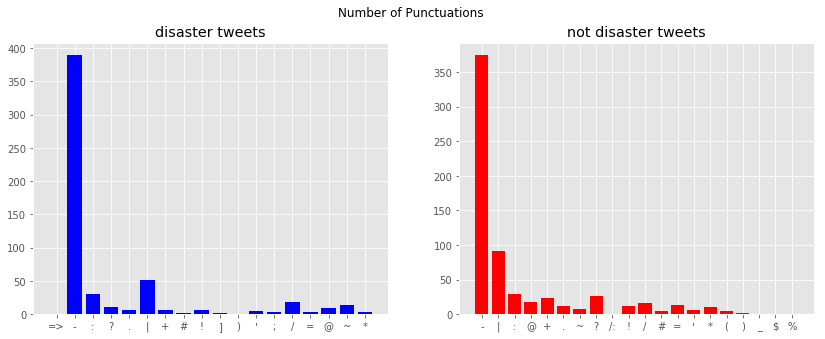

In [65]:
x1, y1 = zip(*dic_punc_disaster.items())
x2, y2 = zip(*dic_punc_not_disaster.items())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(x1, y1, color='blue')
ax1.set_title('disaster tweets')

ax2.bar(x2, y2, color='red')
ax2.set_title('not disaster tweets')

fig.suptitle('Number of Punctuations')
plt.show()

### Common Words

In [66]:
disaster_counter = Counter(disaster_corpus)
disaster_most_common_words = disaster_counter.most_common()

x1 = []
y1 = []

for word, count in disaster_most_common_words[:40]:
    if (word not in stop_words) & (word not in punctuations):
        x1.append(word)
        y1.append(count)
        
not_disaster_counter = Counter(not_disaster_corpus)
not_disaster_most_common_words = not_disaster_counter.most_common()

x2 = []
y2 = []

for word, count in not_disaster_most_common_words[:40]:
    if (word not in stop_words) & (word not in punctuations):
        x2.append(word)
        y2.append(count)

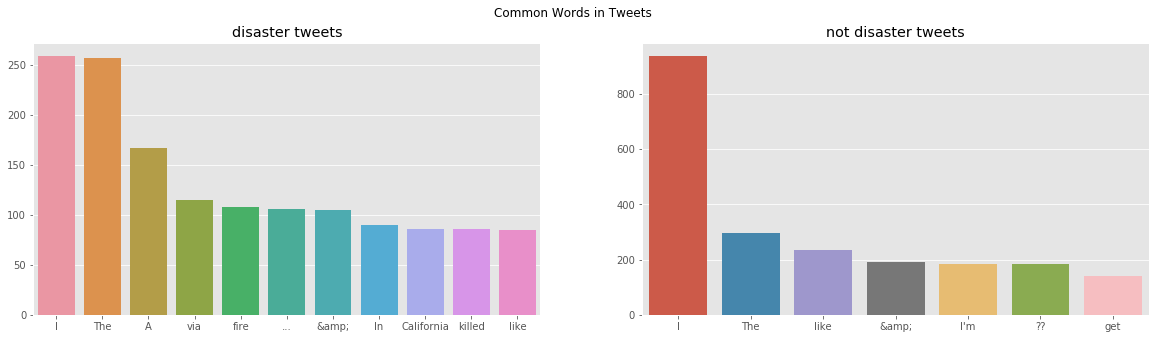

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sns.barplot(x1, y1, ax=ax1)
ax1.set_title('disaster tweets')

sns.barplot(x2, y2, ax=ax2)
ax2.set_title('not disaster tweets')

fig.suptitle('Common Words in Tweets')
plt.show()

Lots of cleaning needed!

### Ngram Analysis

We analyze bigrams (n = 2) and trigrams (n = 3) over tweets. Let's check the most common ngrams in tweets. 

In [68]:
def get_top_tweet_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq

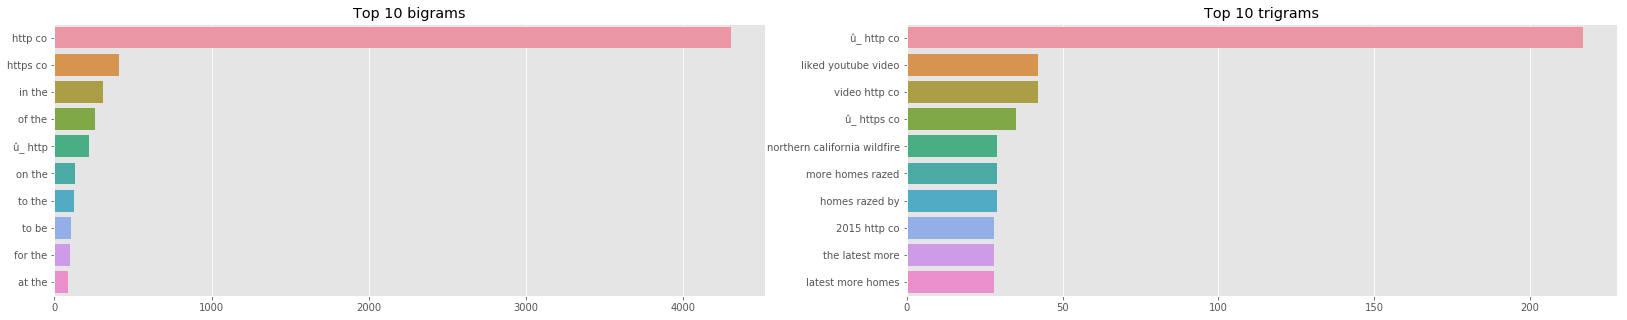

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 5))

top_tweet_bigrams = get_top_tweet_ngrams(train['text'], n=2)[:10]
top_tweet_trigrams = get_top_tweet_ngrams(train['text'], n=3)[:10]

x1, y1 = map(list, zip(*top_tweet_bigrams))
x2, y2 = map(list, zip(*top_tweet_trigrams))

sns.barplot(y1, x1, ax=ax1)
sns.barplot(y2, x2, ax=ax2)
ax1.set_title('Top 10 bigrams')
ax2.set_title('Top 10 trigrams')

plt.show()

A lot of cleaning is needed here too!

### Data Cleaning

* Spelling Correction
* Removing Punctuations
* Removing html tags
* Removing Emojis

In [78]:
df = pd.concat([train, test])
df = df.reset_index(drop=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


### Removing urls

In [80]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [81]:
# remove all urls from df
df['text'] = df['text'].apply(lambda x: remove_url(x))

### Removing HTML Tags

In [82]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [83]:
# remove all html tags from df
df['text'] = df['text'].apply(lambda x: remove_html(x))

 ### Removing Emojis
 
 Emojis can be indactors of some emotionals that can be related to being disaster or not. So, later we should decide if we want to remove them from tweets or not.

In [84]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [85]:
remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [86]:
# remove all emojis from df
df['text'] = df['text'].apply(lambda x: remove_emoji(x))

### Removing Punctuations

In [87]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [88]:
# remove all punctuations from df
df['text'] = df['text'].apply(lambda x: remove_punct(x))

### Spelling Correction

Couldn't install spellchecker package on kaggle teminal!

In [89]:
# from spellchecker import SpellChecker

# spell = SpellChecker()
# def correct_spellings(text):
#     corrected_text = []
#     misspelled_words = spell.unknown(text.split())
#     for word in text.split():
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)
        
# text = "corect me plese"
# correct_spellings(text)

In [90]:
# df['text'] = df['text'].apply(lambda x : correct_spellings(x))

### Glove for Vectorization

In [104]:
def create_corpus(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(tweet) if ((word not in stop_words) & (word.isalpha()==1))]
        corpus.append(words)
    return corpus

In [105]:
corpus = create_corpus(df)

100%|██████████| 10876/10876 [00:03<00:00, 3619.56it/s]


In [116]:
! ls ../input/nlp-getting-started

sample_submission.csv  test.csv  train.csv


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [127]:
! ls

__notebook_source__.ipynb
